In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import partridge as ptg

%matplotlib inline

In [2]:
path = 'data/TriMet-2018-02-06.zip'
date, service_ids = ptg.read_busiest_date(path)

feed = ptg.get_filtered_feed(path, {
    'trips.txt': {'service_id': service_ids, 'direction_id': 0},
    'routes.txt': {'route_short_name': 14},
})

In [3]:
feed.routes

,route_id,agency_id,route_short_name,route_long_name,route_type,route_url,route_color,route_text_color,route_sort_order
8,14,TRIMET,14,Hawthorne,3,http://trimet.org//schedules/r014.htm,NaN,NaN,1700


In [4]:
stop_times = feed.stop_times.sort_values('stop_sequence')
stop_names = dict(feed.stops[['stop_id', 'stop_name']].as_matrix())

In [5]:
patterns = set()
timepoints = set()
distances = defaultdict(list)

for trip_id, stimes in stop_times.groupby('trip_id'):
    patterns.add(tuple(stimes.stop_id))
    timepoints |= set(stimes[stimes.timepoint==1].stop_id)
    for _, stime in stimes.iterrows():
        distances[stime.stop_id].append(stime.shape_dist_traveled)

P = nx.DiGraph()
for pattern in patterns:
    for a, b in zip(pattern[:-1], pattern[1:]):
        P.add_edge(a, b)

Yticks = []
Ylabels = []
for stop_id in nx.topological_sort(P):
    if not timepoints or stop_id in timepoints:
        Yticks.append(np.mean(distances[stop_id]))
        Ylabels.append(stop_names[stop_id])

Yticks[0] = min(Yticks)
Yticks[-1] = max(Yticks)

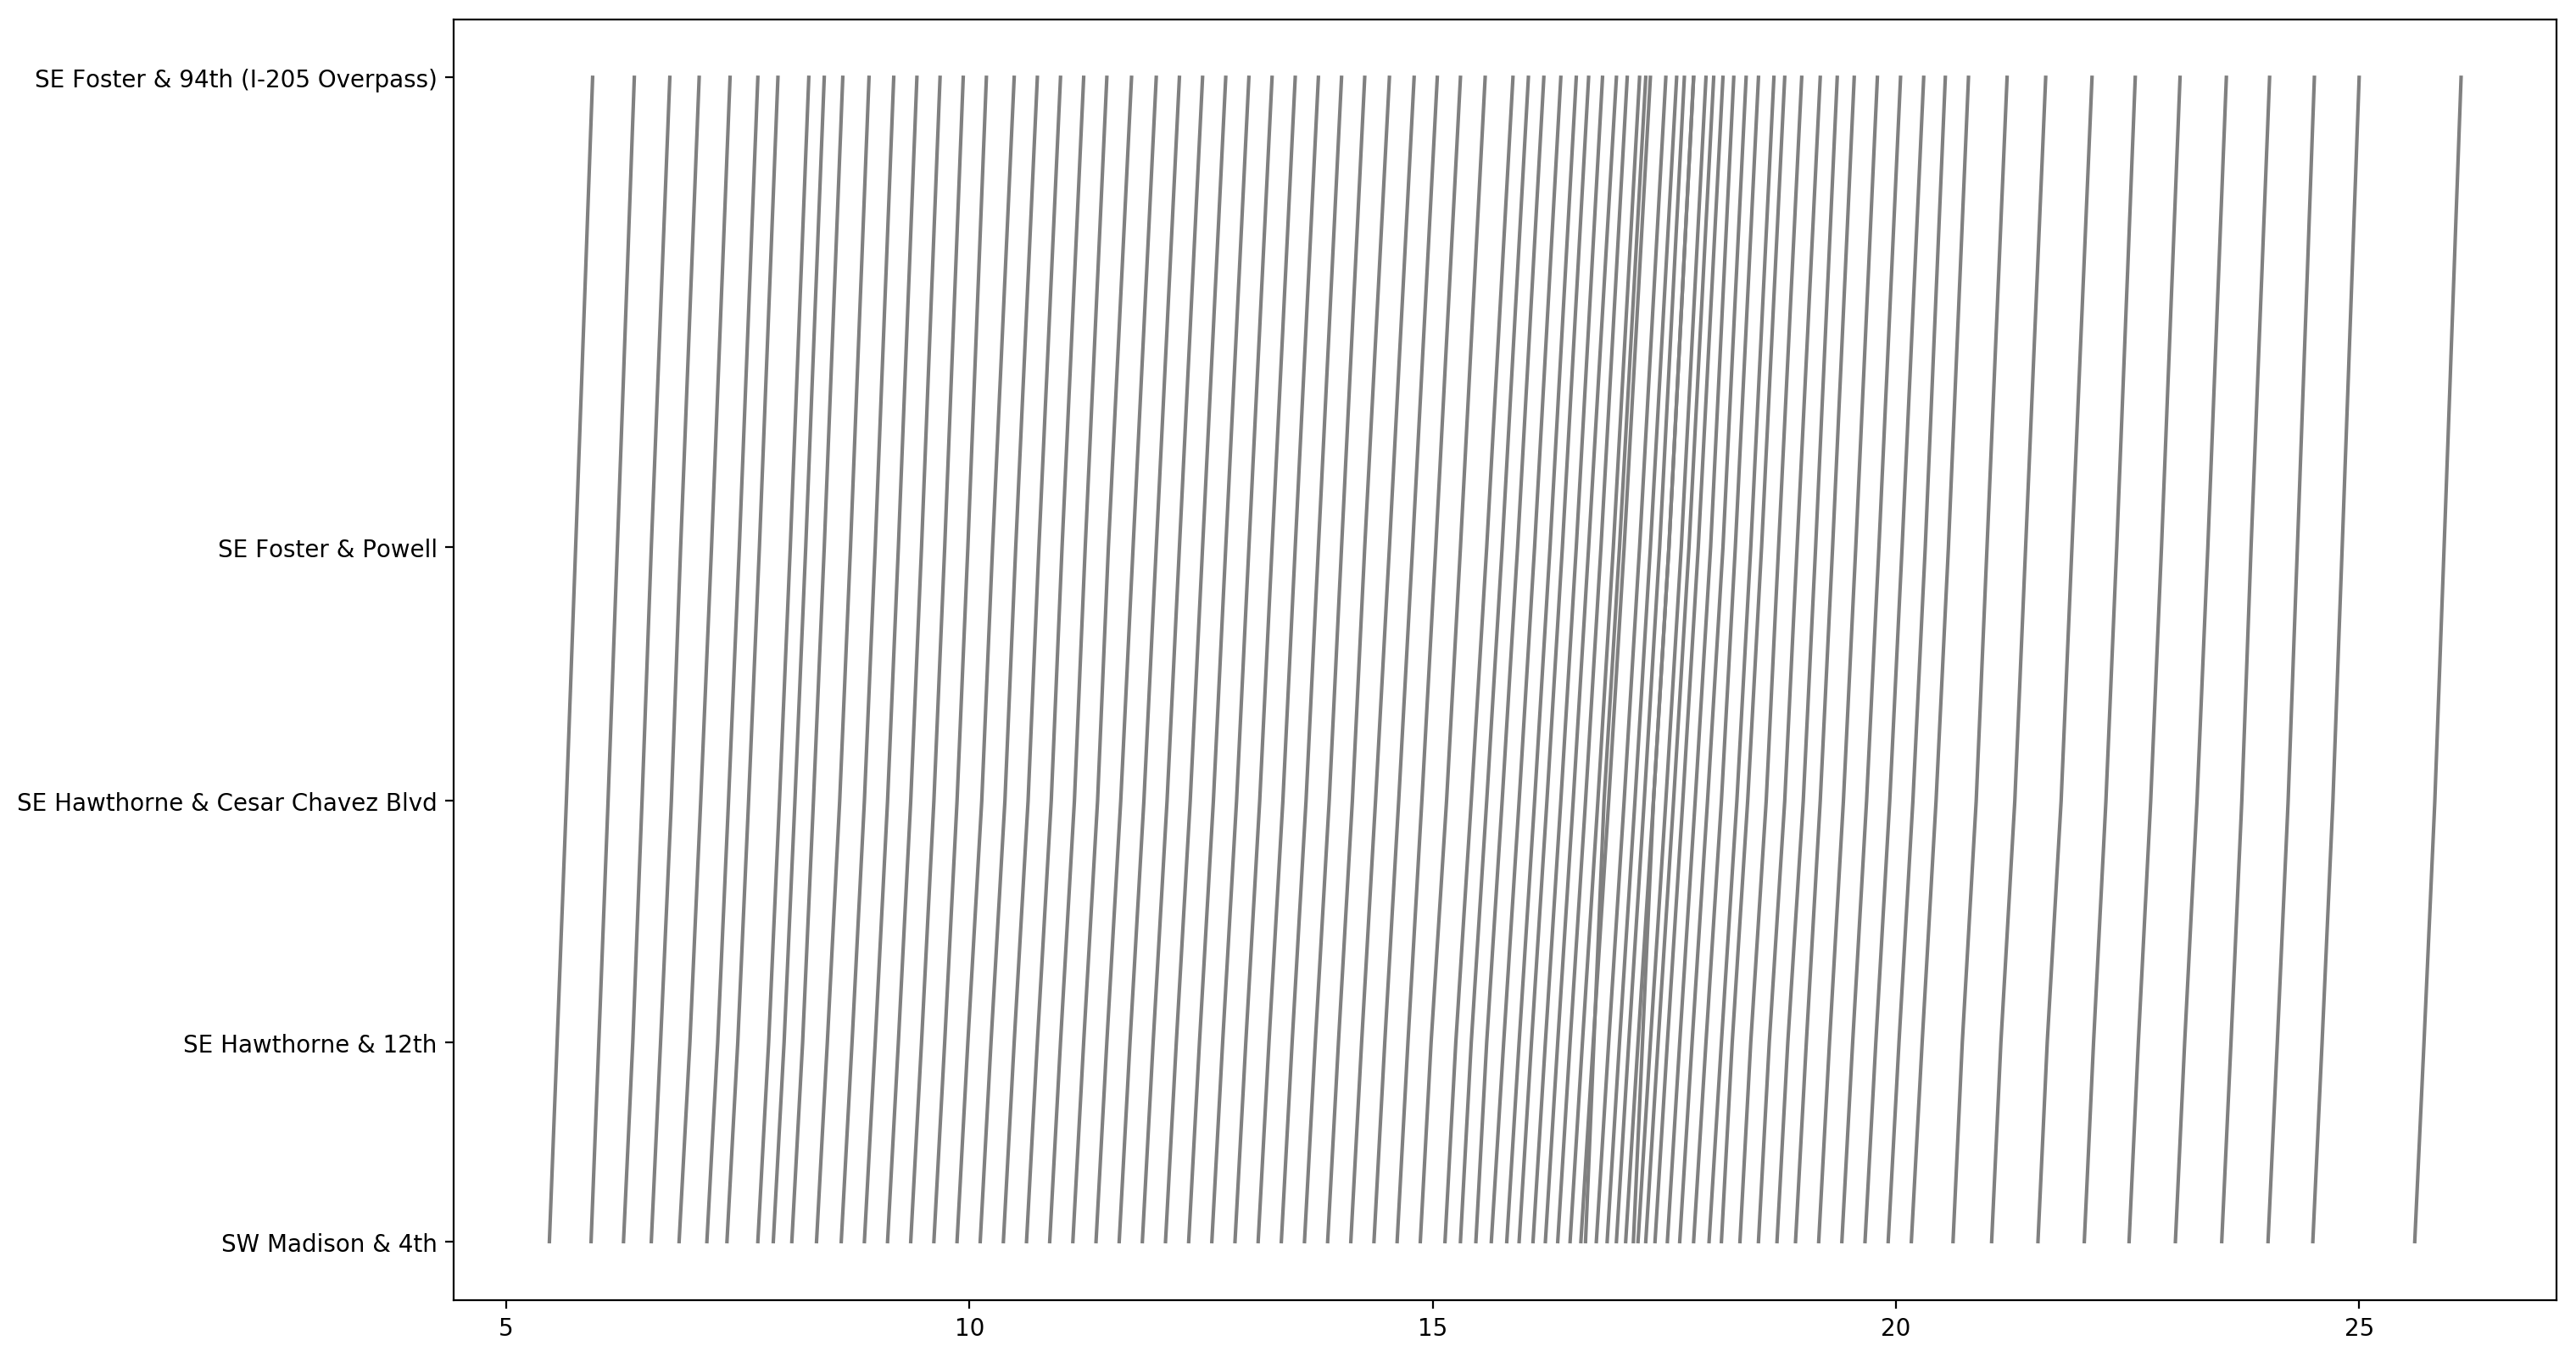

In [6]:
fig = plt.figure(figsize=(16, 10), dpi=200)
ax = fig.add_subplot(111)

for trip_id, stimes in stop_times.groupby('trip_id'):
    arrival_time = stimes.arrival_time / 60 / 60
    _ = ax.plot(arrival_time, stimes.shape_dist_traveled, color='gray')

_ = plt.yticks(Yticks, Ylabels)

plt.show()